# Определение возраста покупателей

<b>Описание проекта</b>
<br>
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.
<br>

<b>План работы по выполнению проекта</b>
<br>
- Проведем исследовательский анализ набора фотографий.
- Подготовим данные к обучению.
- Обучим нейронную сеть и рассчитаем её качество.

## Исследовательский анализ данных

In [1]:
#импортируем необходимые библиотеки

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
#изучим размер выборки

print('Размер выборки для обучения равен:', labels.shape)

Размер выборки для обучения равен: (7591, 2)


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
В предлагаемой выборке содержится порядка 7.5 тыс изображений людей разных возрастов. Данная выборка относительно небольшая, учитывая ту нейросеть, которую мы применяем.
</div>

In [4]:
#подготовим данные для построения графика 

real_age_frame = pd.Series(list(labels.real_age))
real_age_frame

0        4
1       18
2       80
3       50
4       17
        ..
7586    14
7587    37
7588    28
7589    20
7590    47
Length: 7591, dtype: int64

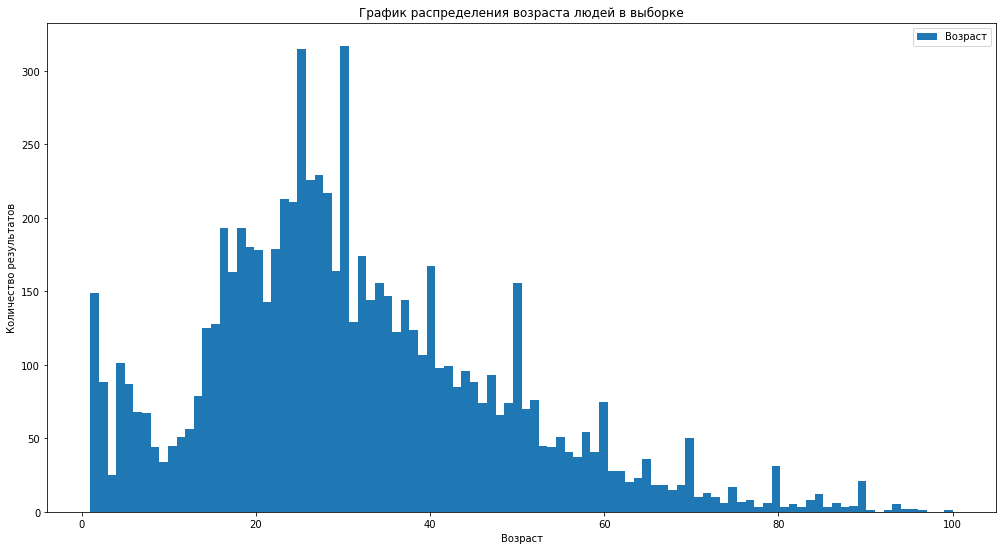

In [5]:
#далее построим график распределения возраста в выборке

plt.figure(figsize=[17,9])
plt.hist(real_age_frame, bins=100, label = 'Возраст')
    
plt.xlabel('Возраст')
plt.ylabel('Количество результатов')

plt.legend(loc='upper right')

plt.title(f'График распределения возраста людей в выборке')
plt.show()

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
В предлагаемой выборке содержится порядка 7.5 тыс изображений людей разных возрастов. Как можно заметить, график распределения имеет форму нормального распределения. Наибольшая часть выборки лежит в пределах от 20 до 40 лет.
</div>

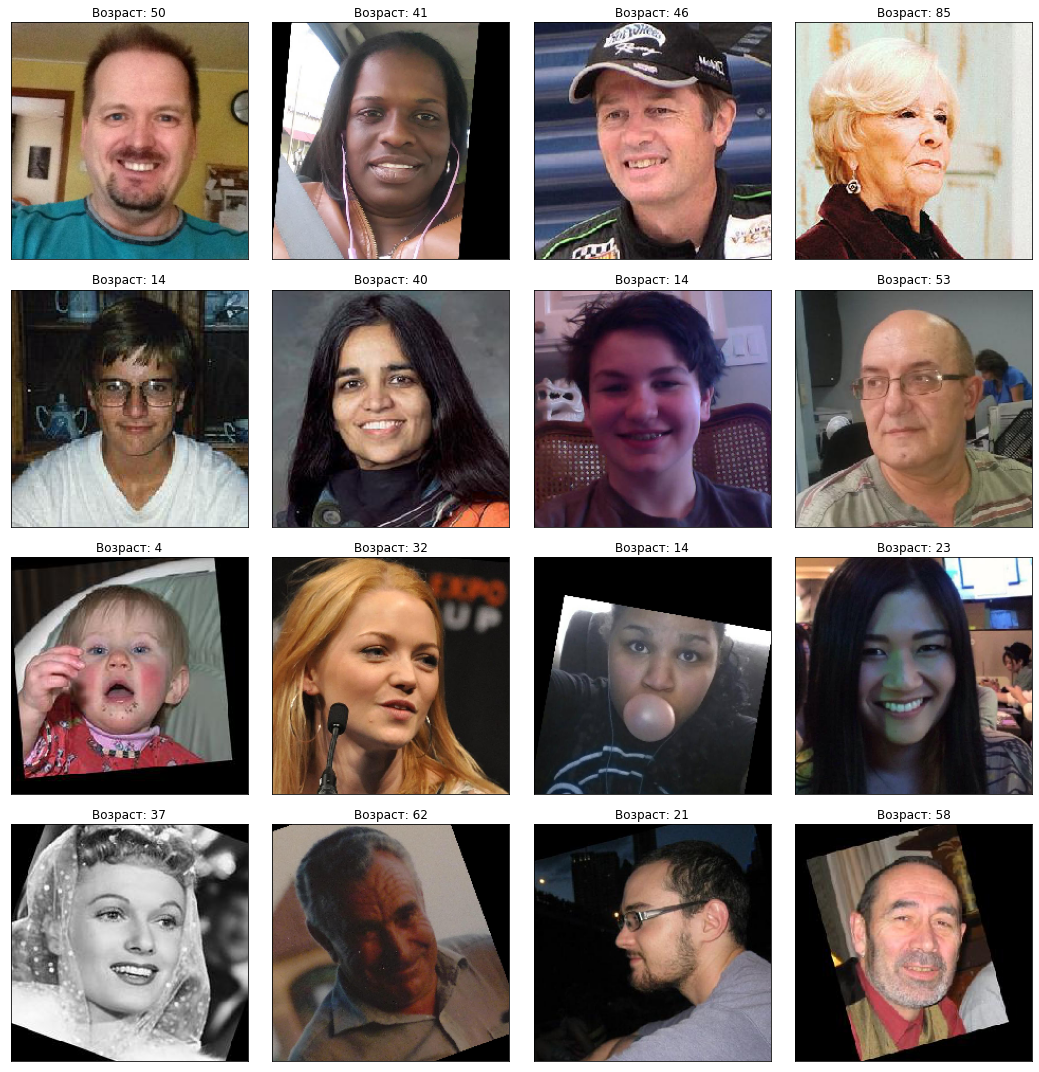

In [6]:
features, target = next(train_gen_flow)

# выводим 15 изображений

fig = plt.figure(figsize=(18,20))
plt.title('Photo Examples', {'fontsize': 20,
 'fontweight' : 10,
 'verticalalignment': 'baseline'})
plt.xticks([])
plt.yticks([])
plt.tight_layout()
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout() 
    plt.title('Age ={}, Image size - {}'.format(target[i], features[i].shape), loc='center')    
    plt.xlabel('Image width, px')
    plt.ylabel('Image height, px')

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>
Данные фотографии достаточно непросты для обучения модели. Часть фотографий повернута, часть представлена в черно-белом формате. Также имеются фотографии, где люди не смотрят в камеру либо какие-то предметы перекрывают часть лица. Большинство фотографий ориентированы корректно, без поворотов. Размер фотографий отличается, встречаются фотографии побольше и лучше качеством, а также встречаются небольшие фотографии с явными пикселями, что гооврит о не очень хорошем качестве.
</div>

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 72s - loss: 211.0951 - mae: 10.4021 - val_loss: 436.4708 - val_mae: 15.7458
Epoch 2/5
356/356 - 39s - loss: 85.2500 - mae: 7.0090 - val_loss: 110.2112 - val_mae: 8.0116
Epoch 3/5
356/356 - 39s - loss: 57.6397 - mae: 5.8285 - val_loss: 81.1850 - val_mae: 6.8230
Epoch 4/5
356/356 - 39s - loss: 42.2970 - mae: 4.9975 - val_loss: 81.5066 - val_mae: 6.5997
Epoch 5/5
356/356 - 38s - loss: 33.8916 - mae: 4.4080 - val_loss: 74.0126 - val_mae: 6.4051

119/119 - 10s - loss: 74.0126 - mae: 6.4051
Test MAE: 6.4051

```

## Анализ обученной модели

<div class="alert alert-info">
<b>Комментарий студента:</b>

- В данном проекте нами была протестирована нейросеть ResNet50 со следующими параметрами: число слоев в модели равно 50, также были отключены два последних слоя, принятые по умолчанию в ResNet и добавлены нами самостоятельно. В качестве инициализации весов использовали параметр 'imagenet' для экономиии времени и повышения качества модели. 
    
    <br>
- Получены результаты по обучению модели для определения возраста людей по фотографии. Нами было получено значение метрики МАЕ ниже 8, что говорит нам об успешности проведенного обучения.
    <br>
   
- По результатам тестирования модели можно сказать о том, что данная модель позволит решить поставленные бизнесом задачи, а именно определить возраст клиентов.
</div>